In [116]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as sci

In [117]:
class Problem_def:
    def __init__(self, N, example, x, u0, u1a, u1b, u2a, u2b, a1_type, b1_type, a2_type, b2_type, vars, hbw):
        self.N = N
        self.example = example
        self.x = x
        self.u0 = u0
        self.u1a = u1a
        self.u1b = u1b
        self.u2a = u2a
        self.u2b = u2b
        self.a1_type = a1_type
        self.b1_type = b1_type
        self.a2_type = a2_type
        self.b2_type = b2_type
        self.vars = vars
        self.hbw = hbw
    
    def d(self, x):
        return 1

    
    def f(self, z, q):
        if q > 0 and z > 0:
            return q * z
        return 0

In [118]:
class SimTime:
    def __init__(self, time, dt, tol, grow_fac, shrink_fac, dtmin, dtmax, endTime, stepsSinceRej, stepsRej, stepsAcc):
        self.time = time
        self.dt = dt
        self.tol = tol
        self.grow_fac = grow_fac
        self.shrink_fac = shrink_fac
        self.dtmin = dtmin
        self.dtmax = dtmax
        self.endTime = endTime
        self.stepsSinceRej = stepsSinceRej
        self.stepsRej = stepsRej
        self.stepsAcc = stepsAcc

In [119]:
### Number of intervals in mesh
N = 100

dx = 10 / 100

x = np.zeros(N + 1)
for i in range(len(x)):
    x[i] = i * dx


grow_fac = 1.25
shrink_fac = 0.8
tol = 1 * (10 ** -2)
dtmin = 1 * (10 ** -4)
dtmax = 1 * (10 ** -1)

def interwoven( R, rows, columns ):
    # convert a stacked form to interwoven
    if rows != len(R) or columns != len(R[0]):
        return 'not valid'
    RI = np.zeros((rows*columns))
    for j in range(columns):
       for i in range(rows):
            RI[j*rows+i] = R[i,j]
    return RI

def stacked( RI, rows, columns):
    # convert an interwoven form to stacked
    if len(RI) != rows * columns:
        return 'not valid'
    R = np.zeros((rows, columns))
    for i in range(rows):
       for j in range(columns):
            R[i,j] = RI[j*rows+i]
    return R

In [121]:
# Residual

def resid(U, dU, t, dt, para):
    res = np.zeros((2, N + 1))
    W = U + dU
    if para.example == 1:
        resZ = res[0]
        resQ = res[1]
        WZ = W[0]
        WQ = W[1]
        dZ = dU[0]
        dQ = dU[1]
    elif para.example == 2:
        resV = res[0]
        resP = res[1]
        WV = W[0]
        WP = W[1]
        dV = dU[0]
        dP = dU[1]
        resV[0] = WV[0]
        resV[-1] = WV[-1]
        resP[-1] = WP[-1]
    
    for i in range(0, N):
        xmid = (x[i] + x[i+1]) / 2
        if para.example == 1:
            Zmid = (WZ[i] + WZ[i+1]) / 2
            Qmid = (WQ[i] + WQ[i+1]) / 2
            resZ[i] += dx/dt * (1/3 * dZ[i] + 1/6 * dZ[i+1]) + para.d(xmid) / dx * (WZ[i] - WZ[i+1]) - para.f(Zmid, Qmid) * dx/2
            resZ[i+1] += dx/dt * (1/6 * dZ[i] + 1/3 * dZ[i+1]) + para.d(xmid) / dx * (WZ[i+1] - WZ[i]) - para.f(Zmid, Qmid) * dx/2
            resQ[i] += (dx/dt) * (1/3 * dQ[i] + 1/6 * dQ[i+1]) + para.f(Zmid, Qmid) / 4
            resQ[i+1] += (dx/dt) * (1/6 * dQ[i] + 1/3 * dQ[i+1]) + para.f(Zmid, Qmid) / 4
        elif para.example == 2:
            resV[i] = (1/dt) * dV[i] + (1/dx) * (WP[i] - WP[i-1])
            resP[i] = (1/dt) * dP[i] + (1/dx) * (WV[i+1] - WV[i])


    if para.example == 1:
        res[0] = resZ
        res[1] = resQ
    elif para.example == 2:
        res[0] = resV
        res[1] = resP

    if para.a1_type == "D":
        res[0][0] = W[0][0] - para.u1a(t)
    if para.a1_type == "N":
        res[0][0] -= para.u1a(t)
    if para.b1_type == "D":
        res[0][-1] = W[0][-1] - para.u1b(t)
    if para.b1_type == "N":
        res[0][-1] += para.u1b(t)
    
    if para.a2_type == "D":
        res[1][0] = W[1][0] - para.u2a(t)
    if para.a2_type == "N":
        res[1][0] -= para.u2a(t)
    if para.b2_type == "D":
        res[1][-1] = W[0][-1] - para.u1b(t)
    if para.b2_type == "N":
        res[1][-1] += para.u2b(t)
    
    return res

In [122]:
def c(U, t, dt, para):
    bw = para.hbw * 2 + 1
    dU = np.zeros((para.vars, N+1))
    Cdata = np.zeros((bw, 2*(N+1)))
    Rbase = resid(U, dU, t, dt, para)
    RbaseI = interwoven(Rbase, para.vars, N+1)
    epsilon = 1 * (10 ** -6)

    for k in range(bw):
        dUI = np.zeros(para.vars * (N+1))
        for i in range(k, len(dUI), bw):
            dUI[i] += epsilon
        dU = stacked(dUI, para.vars, N+1)
        curRes = resid(U, dU, t, dt, para)
        curResI = interwoven(curRes, para.vars, N+1)
        RI = (curResI - RbaseI) / epsilon
        for i in range(k, len(RI), bw):
            for j in range(bw):
                if i+j-para.hbw >= 0 and i+j-para.hbw < len(RI):
                    Cdata[j,i] = RI[i+j-para.hbw]
    
    return Cdata

    

In [123]:
def step(start, stop, U, dt, para):
    triv = 1 * (10 ** -6) * dt
    t = start
    dU = np.zeros((para.vars, N+1))

    while t < stop - triv:
        dU *= 0
        r = resid(U, dU, t, dt, para)
        rI = interwoven(r, para.vars, N+1)
        C = c(U, t, dt, para)
        dUI = sci.solve_banded((para.hbw,para.hbw), C, -rI)
        dU = stacked(dUI, para.vars, N+1)
        U += dU
        t += dt
    return (U, dU)

In [128]:
def copy(old):
    new = np.zeros((len(old), len(old[0])))
    for i in range(len(old)):
        for j in range(len(old[i])):
            new[i][j] = old[i][j]
    return new

def advance(simTime, para, U, timeShots):
    triv = 1 * (10 ** -6) * simTime.dtmin
    timeList = [simTime.time]
    dtList = [simTime.dt]
    errList = []
    UaList = [i[0] for i in U]
    UbList = [i[-1] for i in U]
    U = copy(para.u0)
    timeInd = 0
    UatTimes = [U]
    while simTime.time < simTime.endTime - triv:
        US = copy(U)
        UD = copy(U)
        start = simTime.time
        dt = simTime.dt
        stop = start + dt
        S = step(start, stop, US, dt, para)[0]
        D = step(start, stop, UD, dt / 2, para)[0]
        diff = abs(S - D)
        diffI = interwoven(diff, 2, N+1)
        e_i = max(diffI)
        errList.append(e_i)
        if simTime.dtmin == simTime.dtmax:
            simTime.dt = simTime.dtmin
            simTime.stepsAcc += 1
            simTime.time += simTime.dt
        else:
            if e_i > simTime.tol and simTime.dt > simTime.dtmin:
                simTime.dt = max(simTime.dtmin, simTime.dt / 2)
                simTime.stepsSinceRej = 0
                simTime.stepsRej += 1
                continue
            else:
                simTime.stepsAcc += 1
                simTime.stepsSinceRej += 1
                simTime.time += simTime.dt
                U = 2 * D - S
                if e_i > 0.75 * simTime.tol:
                    simTime.dt *= simTime.shrink_fac
                elif e_i < 0.25 * simTime.tol:
                    if simTime.stepsSinceRej > 1:
                        simTime.dt *= simTime.grow_fac
                simTime.dt = min(simTime.dtmax, max(simTime.dt, simTime.dtmin))
                if simTime.time + simTime.dt > simTime.endTime:
                    simTime.dt = simTime.endTime - simTime.time
                elif simTime.time + 2 * simTime.dt > simTime.endTime:
                    simTime.dt = (simTime.endTime - simTime.time) / 2
        
        if simTime.time - simTime.dt < timeShots[timeInd] and simTime.time >= timeShots[timeInd]:
            timeInd += 1
            UatTimes.append(U)

        timeList.append(simTime.time)
        dtList.append(simTime.dt)
        UaList.append(U[0])
        UbList.append(U[-1])
    return (U, timeList, dtList, errList, UaList, UbList, UatTimes)

/var/folders/2y/vjm7v16d4db4mxgvn7m9c36m0000gn/T/ipykernel_23784/2334992265.py:33: RuntimeWarning: divide by zero encountered in log10
  log[i] = np.log10(dtAdv[i])


Number of steps accepted: 282
Number of steps rejected: 0


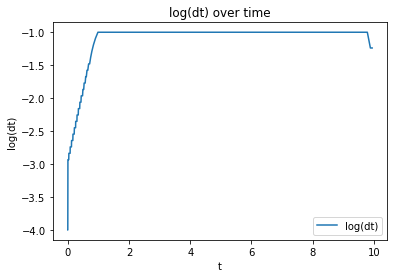

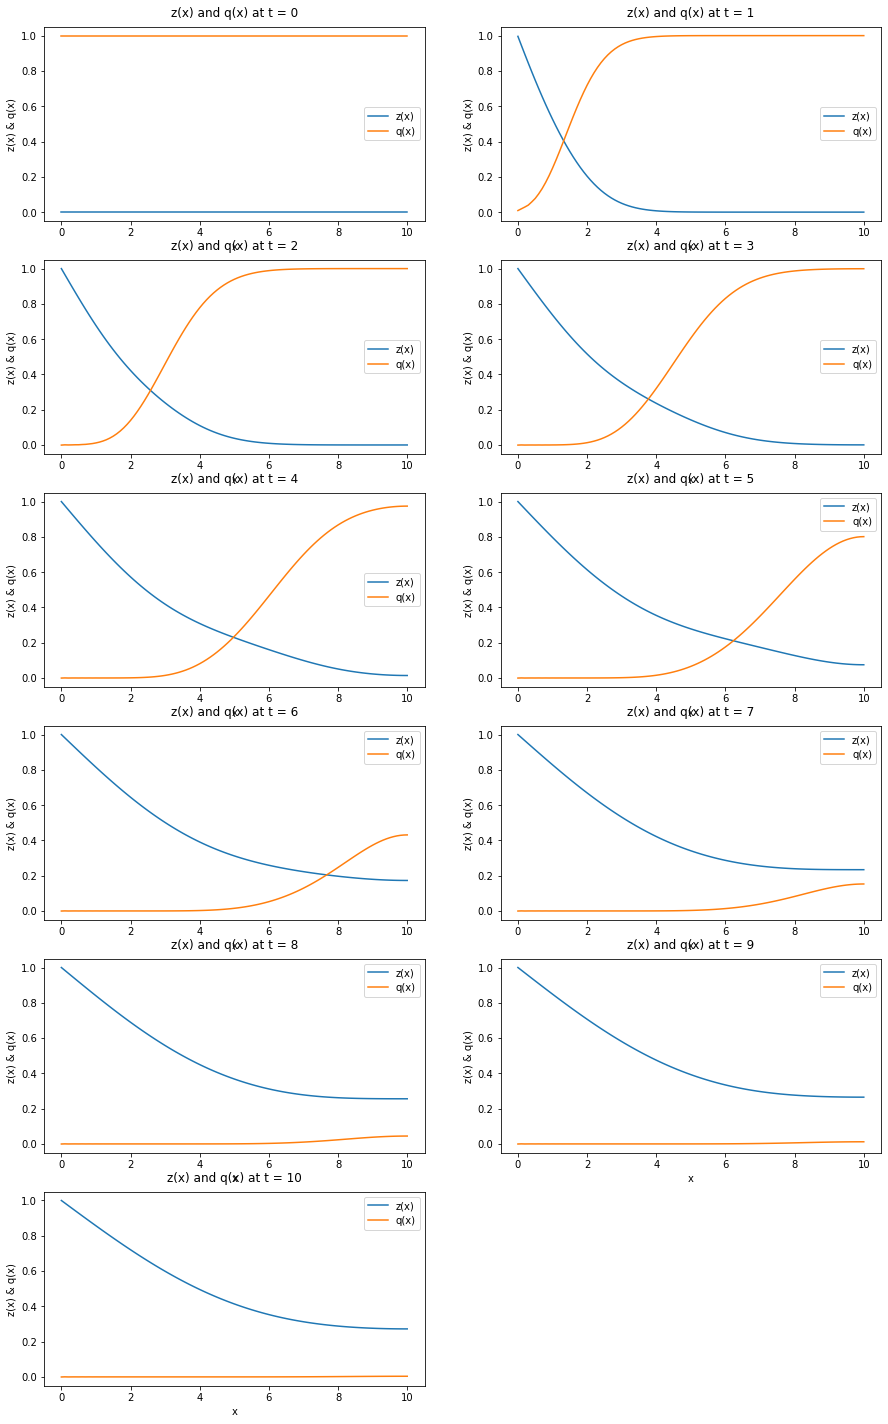

In [125]:
# Problem 1

x = np.zeros(N + 1)
for i in range(N + 1):
    x[i] = i * 10 / 100
z = np.zeros(N + 1)
q = np.ones(N + 1)

timeShots = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

def z_a(t):
    return 1 - np.exp(-5 * t)

def dxz_b(t):
    return 0

def q_a(t):
    return 0

def q_b(t):
    return 0

U = (z,q)

problem1 = Problem_def(N, 1, x, U, z_a, dxz_b, q_a, q_b, 'D', 'N', 'N', 'N', 2, 3)
problem1ST = SimTime(0, 1e-4, 1e-2, grow_fac, shrink_fac, dtmin, dtmax, 10, 0, 0, 0)

adv = advance(problem1ST, problem1, U, timeShots)
timeAdv = adv[1]
dtAdv = adv[2]
log = np.zeros(len(dtAdv))
for i in range(len(dtAdv)):
    log[i] = np.log10(dtAdv[i])
print('Number of steps accepted: ' + str(problem1ST.stepsAcc))
print('Number of steps rejected: ' + str(problem1ST.stepsRej))

fig, ax = plt.subplots()
ax.set_title('log(dt) over time')
ax.set_xlabel('t')
ax.set_ylabel('log(dt)')
ax.plot(timeAdv, log, label='log(dt)')
ax.legend()


fig, ax = plt.subplots(6, 2, figsize = (15,25))
ax[0][0].set_title('z(x) and q(x) at t = 0', pad=10)
ax[0][0].set_xlabel('x')
ax[0][0].set_ylabel('z(x) & q(x)')
ax[0][0].plot(x, adv[6][0][0], label='z(x)')
ax[0][0].plot(x, adv[6][0][1], label='q(x)')
ax[0][0].legend()

ax[0][1].set_title('z(x) and q(x) at t = 1', pad=10)
ax[0][1].set_xlabel('x')
ax[0][1].set_ylabel('z(x) & q(x)')
ax[0][1].plot(x, adv[6][1][0], label='z(x)')
ax[0][1].plot(x, adv[6][1][1], label='q(x)')
ax[0][1].legend()

ax[1][0].set_title('z(x) and q(x) at t = 2', pad=10)
ax[1][0].set_xlabel('x')
ax[1][0].set_ylabel('z(x) & q(x)')
ax[1][0].plot(x, adv[6][2][0], label='z(x)')
ax[1][0].plot(x, adv[6][2][1], label='q(x)')
ax[1][0].legend()

ax[1][1].set_title('z(x) and q(x) at t = 3', pad=10)
ax[1][1].set_xlabel('x')
ax[1][1].set_ylabel('z(x) & q(x)')
ax[1][1].plot(x, adv[6][3][0], label='z(x)')
ax[1][1].plot(x, adv[6][3][1], label='q(x)')
ax[1][1].legend()

ax[2][0].set_title('z(x) and q(x) at t = 4', pad=10)
ax[2][0].set_xlabel('x')
ax[2][0].set_ylabel('z(x) & q(x)')
ax[2][0].plot(x, adv[6][4][0], label='z(x)')
ax[2][0].plot(x, adv[6][4][1], label='q(x)')
ax[2][0].legend()

ax[2][1].set_title('z(x) and q(x) at t = 5', pad=10)
ax[2][1].set_xlabel('x')
ax[2][1].set_ylabel('z(x) & q(x)')
ax[2][1].plot(x, adv[6][5][0], label='z(x)')
ax[2][1].plot(x, adv[6][5][1], label='q(x)')
ax[2][1].legend()

ax[3][0].set_title('z(x) and q(x) at t = 6', pad=10)
ax[3][0].set_xlabel('x')
ax[3][0].set_ylabel('z(x) & q(x)')
ax[3][0].plot(x, adv[6][6][0], label='z(x)')
ax[3][0].plot(x, adv[6][6][1], label='q(x)')
ax[3][0].legend()

ax[3][1].set_title('z(x) and q(x) at t = 7', pad=10)
ax[3][1].set_xlabel('x')
ax[3][1].set_ylabel('z(x) & q(x)')
ax[3][1].plot(x, adv[6][7][0], label='z(x)')
ax[3][1].plot(x, adv[6][7][1], label='q(x)')
ax[3][1].legend()

ax[4][0].set_title('z(x) and q(x) at t = 8', pad=10)
ax[4][0].set_xlabel('x')
ax[4][0].set_ylabel('z(x) & q(x)')
ax[4][0].plot(x, adv[6][8][0], label='z(x)')
ax[4][0].plot(x, adv[6][8][1], label='q(x)')
ax[4][0].legend()

ax[4][1].set_title('z(x) and q(x) at t = 9', pad=10)
ax[4][1].set_xlabel('x')
ax[4][1].set_ylabel('z(x) & q(x)')
ax[4][1].plot(x, adv[6][9][0], label='z(x)')
ax[4][1].plot(x, adv[6][9][1], label='q(x)')
ax[4][1].legend()

ax[5][0].set_title('z(x) and q(x) at t = 10', pad=10)
ax[5][0].set_xlabel('x')
ax[5][0].set_ylabel('z(x) & q(x)')
ax[5][0].plot(x, adv[0][0], label='z(x)')
ax[5][0].plot(x, adv[0][1], label='q(x)')
ax[5][0].legend()

fig.delaxes(ax[5][1])

/var/folders/2y/vjm7v16d4db4mxgvn7m9c36m0000gn/T/ipykernel_23784/3868848935.py:41: RuntimeWarning: divide by zero encountered in log10
  log[i] = np.log10(dtAdv[i])


Number of steps accepted: 133
Number of steps rejected: 0


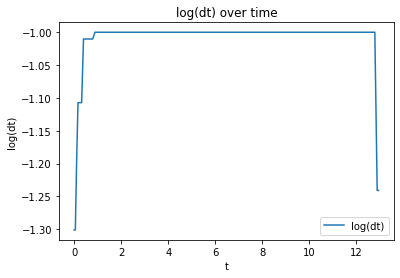

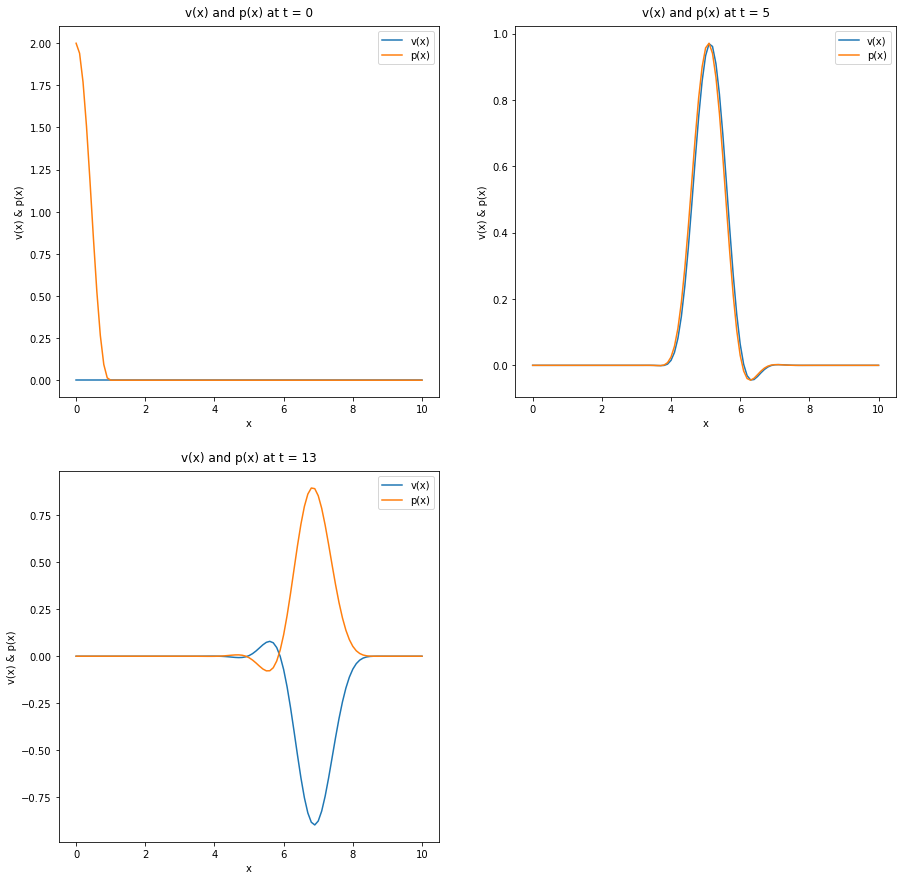

In [129]:
# Problem 2

x = np.zeros(N + 1)
for i in range(N + 1):
    x[i] = i * 10 / 100
v = np.zeros(N + 1)
p = np.zeros(N + 1)

timeShots = [5, 13]

def p0(x):
    if x >= 0 and x <= 1:
        return 2 * (1-x**2)**3
    return 0

for i in range(len(p)):
    p[i] = p0(x[i])

def v_a(t):
    return 0

def v_b(t):
    return 0

def p_a(t):
    return 0

def p_b(t):
    return 0

U = (v,p)

problem2 = Problem_def(N, 2, x, U, v_a, v_b, p_a, p_b, 'D', 'D', 'N', 'N', 2, 3)
problem2ST = SimTime(0, 0.05, 1e-2, grow_fac, shrink_fac, 0.05, 0.05, 13, 0, 0, 0)

adv = advance(problem2ST, problem2, U, timeShots)
timeAdv = adv[1]
dtAdv = adv[2]
log = np.zeros(len(dtAdv))
for i in range(len(dtAdv)):
    log[i] = np.log10(dtAdv[i])
print('Number of steps accepted: ' + str(problem2ST.stepsAcc))
print('Number of steps rejected: ' + str(problem2ST.stepsRej))

fig, ax = plt.subplots()
ax.set_title('log(dt) over time')
ax.set_xlabel('t')
ax.set_ylabel('log(dt)')
ax.plot(timeAdv, log, label='log(dt)')
ax.legend()


fig, ax = plt.subplots(2, 2, figsize = (15, 15))
ax[0][0].set_title('v(x) and p(x) at t = 0', pad=10)
ax[0][0].set_xlabel('x')
ax[0][0].set_ylabel('v(x) & p(x)')
ax[0][0].plot(x, adv[6][0][0], label='v(x)')
ax[0][0].plot(x, adv[6][0][1], label='p(x)')
ax[0][0].legend()

ax[0][1].set_title('v(x) and p(x) at t = 5', pad=10)
ax[0][1].set_xlabel('x')
ax[0][1].set_ylabel('v(x) & p(x)')
ax[0][1].plot(x, adv[6][1][0], label='v(x)')
ax[0][1].plot(x, adv[6][1][1], label='p(x)')
ax[0][1].legend()

ax[1][0].set_title('v(x) and p(x) at t = 13', pad=10)
ax[1][0].set_xlabel('x')
ax[1][0].set_ylabel('v(x) & p(x)')
ax[1][0].plot(x, adv[0][0], label='v(x)')
ax[1][0].plot(x, adv[0][1], label='p(x)')
ax[1][0].legend()

fig.delaxes(ax[1][1])